# Read in Jami Dataset
**make sure to updaet the filepath and energies filepath to point to the right places locally**

In [3]:
import h5py
import pandas as pd

In [4]:
filepath = '../0115_cr4_kd_fitting_jami_bad_read_names_removed'
energies_filepath = '../subopt_attributes4.csv'
f = h5py.File(filepath,'r')

In [5]:
a_group_key = list(f.keys())[0]
dset = f[a_group_key]
data = dset[:]

In [6]:
df = pd.DataFrame(data)
df.sequence = df.sequence.str.decode('utf-8')

In [7]:
df.head()

,sequence,kd,kd_uncertainty,y_intercept,delta_y,count
0,CCATAGAAGGTTATCCGCTA,211.325267,18.164142,31566.195189,100829.0,53
1,CCATAAATAGGTTATCCGCTCA,79.010931,9.586500,30878.403679,100829.0,50
2,CCATAGAAGGTTATCCGCTC,598.991787,65.491251,29898.952995,100829.0,80
3,CCATACAGAGGTTATCCGCCCA,450.662965,45.996410,31034.903539,100829.0,66
4,CCATGAGAGAGGTTATCCGCTGCA,22.894809,2.842569,26789.677027,100829.0,59


# Run Model on Dataset

In [8]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

In [9]:
data = df
#filter the data by kd
data = data[data["kd"] > .1]
energies = pd.read_csv(energies_filepath) #free energy values
#this next line won't be necessary for target7
energies = energies.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
                          'mfold_skew','mfold_median'], axis=1)
energies["sequence"] = energies.Sequence.str.slice(29, -32).str.replace("U", "T")
big_table = pd.merge(energies, data, on='sequence', how="inner")

#columns list needed when we add data later
cols = list(energies.columns)
cols.remove('Sequence')
cols.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence = "CCATAGAGAGGTTATCCGCTCA" #make sure you put in the correct perfect sequence if target 7
PERFECT_KD = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['kd']
PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table['ABA'] = (big_table.kd/PERFECT_KD).apply(np.log)
big_table.head()

,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence,sequence,kd,kd_uncertainty,y_intercept,delta_y,count,ABA
0,-21.9,-16.9,-17.643825,2097,0.751334,-1.611854,-17.4,-19.200001,-19.856,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,CCATGGAGAGGTTATCCTCTCA,519.496637,5.596218e+01,32282.306295,100829.0,49,4.122820
1,-23.9,-18.9,-19.735792,1288,0.838893,-1.601279,-19.5,-21.100000,-21.820,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,CCATAGAGAGGATCCGCTCA,446.092109,3.968503e+01,31875.888595,100829.0,80,3.970485
2,-15.5,-10.5,-11.225309,10127,0.724902,-1.580592,-11.0,-13.700000,-14.197,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,CCATAGAGAGGTTATCCGCCTACA,97.342046,9.124724e+00,31675.359474,100829.0,54,2.448190
3,-19.5,-14.5,-15.347548,4894,0.831892,-1.490905,-15.1,-17.700001,-18.254,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,CCATAGATGAGGTTATCCGCTGCA,8016.794543,9.237507e+07,28921.910003,100829.0,57,6.859253
4,-15.7,-10.7,-11.386458,4630,0.699062,-1.641765,-11.2,-13.400000,-13.914,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,CCATACTCTCCAATAGGGCTCA,1624.309403,5.554203e+02,28143.816280,100829.0,72,5.262797


In [12]:
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(x, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions

#think of data_matrix as input and output variable as output
seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()

#relative encoding scheme
def create_matrix():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

#absolute encoding scheme example
def create_matrix_0(randomize=True):
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            #coords = get_diff(perfect_sequence, seq)
            #if len(coords) > 5:
            #    pass
            #else:
            row = [0 for i in range(4*max_len)]
            for i in range(len(seq)):
                if seq[i] == 'A':
                    row[i*4 + 0] = 1
                elif seq[i] == 'C':
                    row[i*4 + 1] = 1
                elif seq[i] == 'G':
                    row[i*4 + 2] = 1
                elif seq[i] == 'T':
                    row[i*4 + 3] = 1
                else:
                    print("Impossible happened check seq values", seq)
                #row[get_position(coord)] = 1
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            pruned_combined_data_matrix.append(row)
            pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    if randomize:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    return X, y

def hinge(x, exp=1):
    return min(x, 6**exp)
vhinge = np.vectorize(hinge)

#including free energy feature(s)
def create_matrix2():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])

    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

# the start of this function is same as before
#adding pooling features
def create_matrix3():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

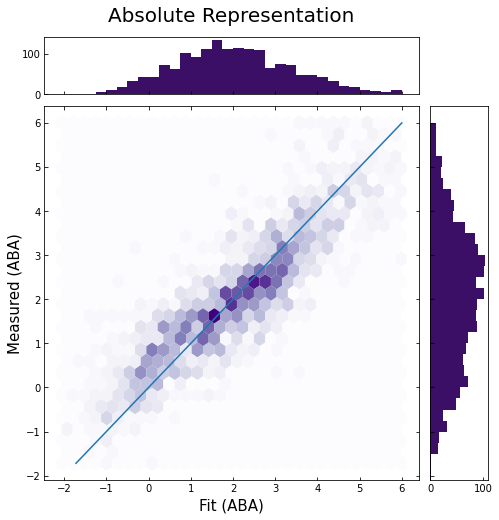

test correlation is 0.8692136298514578


In [14]:
#plug in your favorite model
X,y = create_matrix2()

#just to show that we aren't really over-fitting
cutoff = 3000

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(vhinge(predicted_output), y_test, title="Absolute Representation")
corr, p_value = pearsonr(vhinge(predicted_output), y_test)
print("test correlation is",corr)